In [2]:
from imaris_ims_file_reader.ims import ims


In [ ]:
# myFile = '/Users/dpark9941/Desktop/Jang_neuron_seg/Jang_tracings/ims/TBX DIO TRE-XFP ScalesSQ 20x 1.0Wtile stack_Subset_Stitch_1_filaments.ims'
# a = ims(myFile.ims)

# # Slice a like a numpy array always with 5 axes to access the highest resolution - level 0 - (t,c,z,y,x)
# a[0,0,5,:,:] # Time point 0, Channel 0, z-layer 5

# # Slice in 6 axes to designate the desired resolution level to work with - 0 is default and the highest resolution
# a[3,0,0,5,:,:] # Resolution Level 3, Time point 0, Channel 0, z-layer 5

# print(a.ResolutionLevelLock)
# print(a.ResolutionLevels)
# print(a.TimePoints)
# print(a.Channels)
# print(a.shape)
# print(a.chunks)
# print(a.dtype)
# print(a.ndim)

# # A 'resolution lock' can be set when making the class which allows for 5 axis slicing that always extracts from that resoltion level
# a = ims(myFile.ims,ResolutionLevelLock=3)

# # Change ResolutionLevelLock after the class is open
# a.change_resolution_lock(2)
# print(a.ResolutionLevelLock)

# # The 'squeeze_output' option returns arrays in their reduced form similar to a numpy array.  This is True by default to maintain behavior similar to numpy; however, some applications may benefit from predictably returning a 5 axis array.  For example, napari prefers to have outputs with the same number of axes as the input.
# a = ims(myFile.ims)
# print(a[0,0,0].shape)
# #(1024,1024)

# a = ims(myFile.ims, squeeze_output=False)
# print(a[0,0,0].shape)
# #(1,1,1,1024,1024)

# #########################################################
# ###  Open the Imaris file as a Zarr Store (read only) ###
# #########################################################
# from imaris_ims_file_reader.ims import ims
# import zarr

# store = ims(myFile.ims,ResolutionLevelLock=2, aszarr=True)
# print(store)
# #<imaris_ims_file_reader.ims_zarr_store.ims_zarr_store object at 0x7f48965f9ac0>

# # The store object is NOT a sliceable array, but it does have arrtibutes that describe what to expect after opening the store.
# print(store.ResolutionLevelLock)
# print(store.ResolutionLevels)
# print(store.TimePoints)
# print(store.Channels)
# print(store.shape)
# print(store.chunks)
# print(store.dtype)
# print(store.ndim)

# zarray = zarr.open(store,mode='r')
# print(store.shape)
# print(store.chunks)
# print(store.dtype)
# print(store.ndim)

# print(zarray[0,0,0].shape)
# #(1024,1024)

In [3]:
import h5py
import numpy as np

# .ims 파일 경로
ims_path = '/Users/dpark9941/Desktop/Jang_neuron_seg/data/Jang_tracings/TBX DIO TRE-XFP ScalesSQ 20x 1.0Wtile stack_Subset_Stitch_1_filaments.ims'

# 파일 열기 (읽기 모드)
with h5py.File(ims_path, 'r') as f:
    print("=== IMS file structure ===")
    
    # 계층 구조 탐색 함수
    def print_structure(name, obj):
        if isinstance(obj, h5py.Group):
            print(f"[Group] {name}")
        elif isinstance(obj, h5py.Dataset):
            print(f"[Dataset] {name} | shape: {obj.shape} | dtype: {obj.dtype}")
    
    # 파일 전체 구조 프린트
    f.visititems(print_structure)
    
    # 예시: 첫 번째 채널의 3D 데이터 읽기
    data_path = "/DataSet/ResolutionLevel 0/TimePoint 0/Channel 0/Data"
    if data_path in f:
        data = f[data_path][()]  # numpy array로 로드
        print(f"\nLoaded dataset shape: {data.shape}, dtype: {data.dtype}")
    else:
        print(f"{data_path} not found in file")

=== IMS file structure ===
[Group] DataSet
[Group] DataSet/ResolutionLevel 0
[Group] DataSet/ResolutionLevel 0/TimePoint 0
[Group] DataSet/ResolutionLevel 0/TimePoint 0/Channel 0
[Dataset] DataSet/ResolutionLevel 0/TimePoint 0/Channel 0/Data | shape: (144, 1024, 2048) | dtype: uint16
[Dataset] DataSet/ResolutionLevel 0/TimePoint 0/Channel 0/Histogram | shape: (256,) | dtype: uint64
[Group] DataSet/ResolutionLevel 0/TimePoint 0/Channel 1
[Dataset] DataSet/ResolutionLevel 0/TimePoint 0/Channel 1/Data | shape: (144, 1024, 2048) | dtype: uint16
[Dataset] DataSet/ResolutionLevel 0/TimePoint 0/Channel 1/Histogram | shape: (256,) | dtype: uint64
[Group] DataSet/ResolutionLevel 0/TimePoint 0/Channel 2
[Dataset] DataSet/ResolutionLevel 0/TimePoint 0/Channel 2/Data | shape: (144, 1024, 2048) | dtype: uint16
[Dataset] DataSet/ResolutionLevel 0/TimePoint 0/Channel 2/Histogram | shape: (256,) | dtype: uint64
[Group] DataSet/ResolutionLevel 1
[Group] DataSet/ResolutionLevel 1/TimePoint 0
[Group] Dat

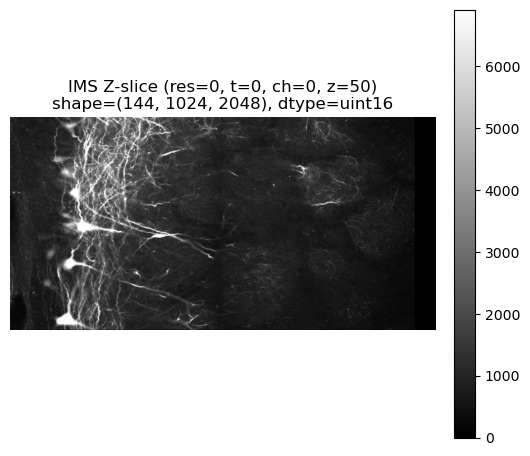

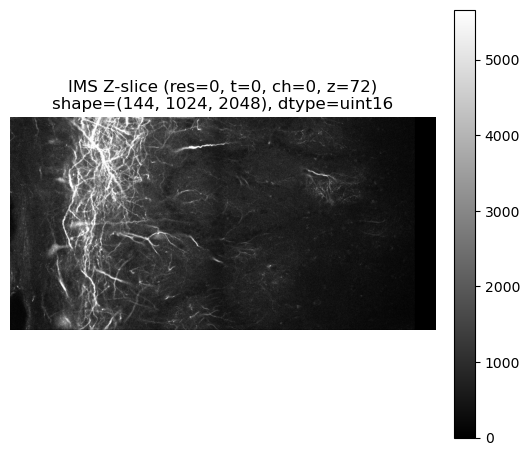

In [4]:

import matplotlib.pyplot as plt

def get_dataset_path(res=0, t=0, ch=0):
    return f"/DataSet/ResolutionLevel {res}/TimePoint {t}/Channel {ch}/Data"

def show_ims_zslice(ims_path, z_idx=None, res=0, t=0, ch=0, cmap='gray',
                    use_percentile=True, prct=(1, 99)):
    """
    ims_path: .ims 파일 경로
    z_idx: 표시할 z 인덱스 (None이면 가운데 슬라이스)
    res, t, ch: ResolutionLevel, TimePoint, Channel 선택
    use_percentile: 명암 자동 스케일(퍼센타일) 사용할지 여부
    prct: (하위, 상위) 퍼센타일
    """
    with h5py.File(ims_path, 'r') as f:
        dpath = get_dataset_path(res, t, ch)
        if dpath not in f:
            raise KeyError(f"Dataset not found: {dpath}")

        ds = f[dpath]          # HDF5 Dataset
        shape = ds.shape       # (Z, Y, X)
        if len(shape) != 3:
            raise ValueError(f"Expected 3D volume (Z,Y,X), got shape={shape}")

        # z 인덱스 자동 선택(가운데)
        if z_idx is None:
            z_idx = shape[0] // 2

        if not (0 <= z_idx < shape[0]):
            raise IndexError(f"z_idx={z_idx} out of range (0..{shape[0]-1})")

        # 필요한 슬라이스만 로드 (메모리 절약)
        zslice = ds[z_idx, :, :]

        # 표시용 명암 범위 계산 (uint16 등 대비 향상)
        if use_percentile:
            vmin, vmax = np.percentile(zslice, prct)
        else:
            vmin, vmax = None, None

        plt.figure(figsize=(6,6))
        im = plt.imshow(zslice, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.title(f"IMS Z-slice (res={res}, t={t}, ch={ch}, z={z_idx})\nshape={shape}, dtype={ds.dtype}")
        plt.axis('off')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.show()

# 사용 예시
show_ims_zslice(ims_path, z_idx=50, res=0, t=0, ch=0)   # 특정 z
show_ims_zslice(ims_path)                               # 가운데 z (자동)

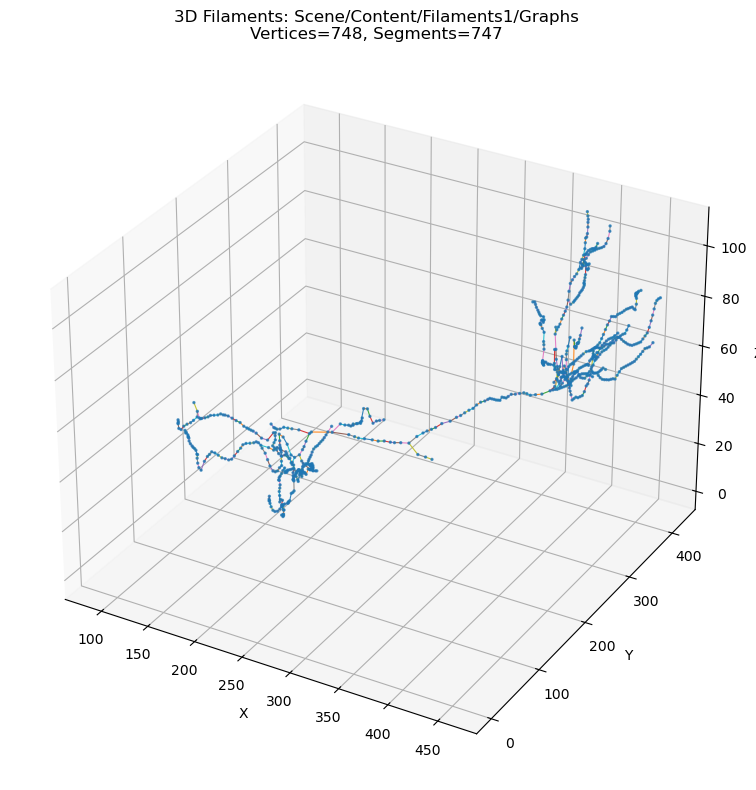

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa


def list_filament_groups(ims_path):
    groups = []
    with h5py.File(ims_path, 'r') as f:
        base = "Scene/Content"
        if base not in f:
            raise KeyError(f"'{base}' not found in file")
        for k in f[base].keys():
            if k.startswith("Filaments"):
                g = f[f"{base}/{k}"]
                if "Graphs" in g:
                    groups.append(f"{base}/{k}/Graphs")
    return groups

# 예시
# print(list_filament_groups("example.ims"))
def visualize_filaments_3d_ims(ims_path, graphs_group):
    """
    ims_path: .ims 파일 경로
    graphs_group: 예) "Scene/Content/Filaments0/Graphs"
    """
    with h5py.File(ims_path, 'r') as f:
        v_path = f"{graphs_group}/Vertices"
        e_path = f"{graphs_group}/Segments"
        if v_path not in f or e_path not in f:
            raise KeyError(f"Required datasets not found: {v_path}, {e_path}")

        V = np.asarray(f[v_path])      # shape (N, 5) -> [X,Y,Z,R,T]
        E = np.asarray(f[e_path])      # shape (M, 2) -> [u,v] index pairs

    # 좌표만 추출
    X, Y, Z = V[:,0], V[:,1], V[:,2]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    # 간선 그리기
    for (u, v) in E:
        p1 = V[u, :3]
        p2 = V[v, :3]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]],
                linewidth=0.8, alpha=0.9)

    # 정점 찍기 (옵션: 반지름/시간에 따라 색/크기 바꿀 수 있음)
    ax.scatter(X, Y, Z, s=2, alpha=0.7)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(f"3D Filaments: {graphs_group}\nVertices={len(V)}, Segments={len(E)}")
    plt.tight_layout()
    plt.show()

# 사용 예시
groups = list_filament_groups(ims_path)
visualize_filaments_3d_ims(ims_path, groups[1])

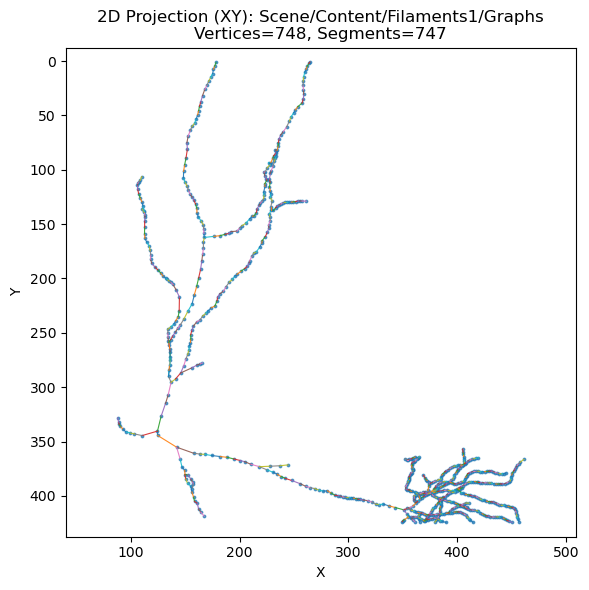

In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def visualize_filaments_2d_ims(ims_path, graphs_group, proj="xy", invert_y=True):
    """
    proj: "xy", "xz", "yz" 중 선택
    """
    with h5py.File(ims_path, 'r') as f:
        v_path = f"{graphs_group}/Vertices"
        e_path = f"{graphs_group}/Segments"
        if v_path not in f or e_path not in f:
            raise KeyError(f"Required datasets not found: {v_path}, {e_path}")

        V = np.asarray(f[v_path])      # (N,5): [X,Y,Z,R,T]
        E = np.asarray(f[e_path])      # (M,2)

    # 투영축 선택
    if proj == "xy":
        i, j = 0, 1
        xlabel, ylabel = "X", "Y"
    elif proj == "xz":
        i, j = 0, 2
        xlabel, ylabel = "X", "Z"
    elif proj == "yz":
        i, j = 1, 2
        xlabel, ylabel = "Y", "Z"
    else:
        raise ValueError("proj must be one of {'xy','xz','yz'}")

    plt.figure(figsize=(6,6))

    for (u, v) in E:
        p1 = V[u, :]
        p2 = V[v, :]
        plt.plot([p1[i], p2[i]], [p1[j], p2[j]], linewidth=0.8, alpha=0.9)

    plt.scatter(V[:, i], V[:, j], s=3, alpha=0.7)

    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.title(f"2D Projection ({proj.upper()}): {graphs_group}\nVertices={len(V)}, Segments={len(E)}")
    plt.axis("equal")
    if invert_y and proj in ("xy",):
        plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# 사용 예시
visualize_filaments_2d_ims(ims_path, groups[1], proj="xy")